# Load prior saved versions of x,y datasets below while updates in progress for building datasets code

#### GRID SEARCHES AND TIME CONSUMING ALGORITHM'S ARE CURRENTLY TRAINED ON A 10,000 INSTANCE SUBSET FOR NOW

# Summary of Results

In [2]:
# plt.figure(figsize = (10,5))
# plt.bar(summary_df.Models, summary_df.Scores)
# plt.xticks(rotation=45)
# plt.xticks(fontsize = 12)
# plt.axhline(y = -model_summary["Baseline Guesser"]["Score"], color = 'k', linestyle = 'dashed')     
# plt.title("Final Log Loss by Model", fontsize=16)
# summary_df[["Models", "Scores"]]

# Training Models

In [4]:
import pandas as pd
import numpy as np
import pickle as pkl
import random
import time
import math
import sklearn
import itertools
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.preprocessing import MultiLabelBinarizer, OrdinalEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, cross_validate, cross_val_predict, GridSearchCV
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.exceptions import ConvergenceWarning

#from cloud_modules import cloud_functions as cf
#from build_datasets import constants
import json


warnings.simplefilter("ignore")


### Load Saved Training Data from 2016-2018

In [5]:
with open("../build_datasets/Data/final_training_data_2016.pkl", "rb") as file:
    data = pkl.load(file)
    x = data['X']
    y = data['y_play'] # Later we can also include the on_base targets


### Odds Functions

In [6]:
# League Average Guesser
def average_guesser(league_percentages, pitbat_combo):
    ab_percentages = {}
    
    for play in constants.PLAY_TYPES:
        league_percent = league_percentages[pitbat_combo][play]
        ab_percentages[play] = league_percent
        
    ab_percentages = {key: value/sum(list(ab_percentages.values())) for key, value in ab_percentages.items()}
    
    return ab_percentages  

In [7]:
def log_loss(probabilities, actuals):
    """ Given a list of probabilities and acuals for a series of instances, calculate and return the average log loss"""
    log_loss = 0
    yhat_probabilities = []
    for instance in range(len(probabilities)):
        yhat_probabilities.append(max([n for n in np.array(probabilities.iloc[instance])*np.array(actuals.iloc[instance])])) # max of array of percentages guessed times binay vector of actuals for the play, eg just the percentage guessed of the actual
    log_loss -= sum([np.log10(x)for x in yhat_probabilities])


    return log_loss/len(probabilities)

# ML Algorithms

In [8]:
# x_train, x_test, y_train, y_test = train_test_split(ml_full_df, y_full, test_size=0.2, random_state=42)
sss = StratifiedShuffleSplit(test_size=.2, random_state=42)
for train_index, test_index in sss.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [12]:
def plot_model_error_on_n(model, n1, n2, model_name = "The Model", x_train=x_train, y_train=y_train, n_jobs=5):
    score_dict = {}
    for n in [x for x in range (n1,n2+1000) if x%1000==0]:
        print("Training Model on {} Instances".format(n))
        score = cross_val_score(model, x_train[:n], y_train[:n], cv=5, scoring="neg_log_loss", verbose=3, error_score="raise", n_jobs=n_jobs)
        score_dict[n] = -score.mean()
        clear_output(wait=False)
    plt.plot(score_dict.keys(), score_dict.values())
    plt.title("{} Log Loss With Sample Size n".format(model_name))

## Poor Average Estimator

In [9]:
dumb_log_loss_plays = 0
league_averages_plays = {}
for play in np.unique(y_train):
    play_share = len(y_train[y_train == play])/len(y_train)

    league_averages_plays[play] = play_share
    dumb_log_loss_plays += play_share * np.log(play_share) # Generalization of the log loss formula to a baseline guesser case
    
    
print("The Crappy Average Estimator for Predicting Plays Has a Neg Log Loss of: {}".format(round(dumb_log_loss_plays,3)))
#print("The Crappy Average Estimator for Predicting On Base Has a Neg Log Loss of: {}".format(round(dumb_log_loss_onbase,3)))

The Crappy Average Estimator for Predicting Plays Has a Neg Log Loss of: -1.678


## Regressions

### Basic Logistic Regresssion

In [10]:
# Set up a logistic regression on the full x,y train datasets and check the baseline log_loss
softmax = LogisticRegression(class_weight = None, max_iter=150)
softmax_scores = cross_val_score(softmax, x_train[:], y_train[:], cv=5, scoring = "neg_log_loss", n_jobs=4)
clear_output(wait=False)
print("The Basic Logistic Regressor Has a Neg Log Loss of: {}".format(round(softmax_scores.mean(),3)))

The Basic Logistic Regressor Has a Neg Log Loss of: -1.612


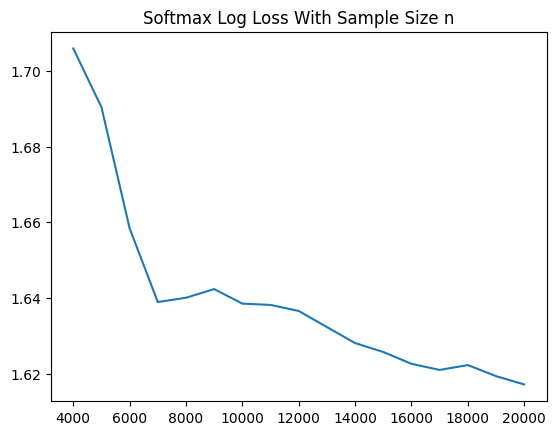

In [13]:
# Check approx where softmax error starts to plateau based on n instances for cutting off grid search
plot_model_error_on_n(softmax, 4000, 20000, "Softmax")

### Grid Search Logistic Regression

In [14]:
# Build a Dictionary of class weights to grid search on due to impalanced Dataset
class_weights = list(np.unique(y_train))
class_weights_list = []

for n in range(10):
    weights = np.random.rand(len(class_weights))
    weights = weights/sum(weights)
    weights = {class_weights[x]:weights[x] for x in range(len(class_weights))}
    
    class_weights_list.append(weights)
class_weights.append("balanced")
    
class_weights_list.append(None)

In [15]:
# Build a parameter dictionary to grid search the logistic regression on 
parameters = {'C':np.linspace(0.001,1,7), "class_weight":class_weights_list, 'multi_class':["ovr"], "solver":["saga"]} # Prior searching on the data told us saga and ovr

grid_search = GridSearchCV(LogisticRegression(), parameters, cv=5, scoring = "neg_log_loss", verbose = 3, n_jobs = 4)
grid_search.fit(x_train[:12500], y_train[:12500])
clear_output(wait=False)

In [16]:
final_logistic_regressor = grid_search.best_estimator_
print("The Best Logistic Regressor Has a Neg Log Loss Of: {}".format(round(grid_search.best_score_.mean(), 3)))
print("The Best Logistic Regressor Has Parameters Of: {}".format(grid_search.best_params_))

The Best Logistic Regressor Has a Neg Log Loss Of: -1.617
The Best Logistic Regressor Has Parameters Of: {'C': 0.667, 'class_weight': None, 'multi_class': 'ovr', 'solver': 'saga'}


In [17]:
# Because we grid searched for parameters on a smaller dataset, run the final estimator on the full dataset for a best score
final_softmax_scores = cross_val_score(final_logistic_regressor, x_train[:], y_train[:], cv=5, scoring = "neg_log_loss", n_jobs=-1)
clear_output(wait=False)
print("The Final Logistic Regressor Has a Neg Log Loss of: {}".format(round(final_softmax_scores.mean(),3)))

The Final Logistic Regressor Has a Neg Log Loss of: -1.611


## K Neighbors Classifier

### Basic K Neighbors Classifier

In [35]:
knc = KNeighborsClassifier(n_neighbors = 1000)

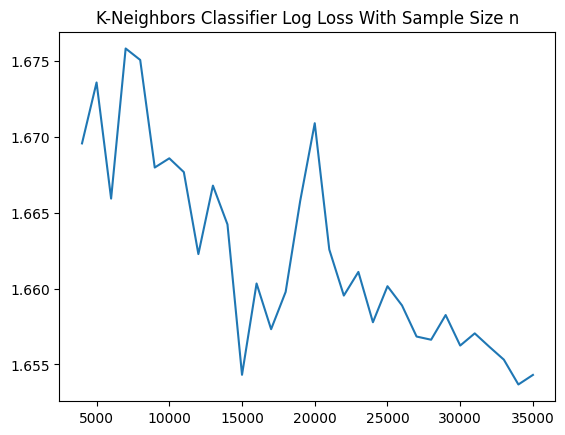

In [36]:
# Check approx where KNC error starts to plateau based on n instances for cutting off grid search and understanding training timing
plot_model_error_on_n(knc, 4000, 35000, "K-Neighbors Classifier")

In [37]:
knc_scores = cross_val_score(knc, x_train[:100000], y_train[:100000], cv=5, scoring = "neg_log_loss", n_jobs=4, verbose = 4)
print("The Basic kNeighbors Classifier Has a Neg Log Loss of: {}".format(round(knc_scores.mean(),3)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END ............................... score: (test=-1.637) total time=  20.9s
[CV] END ............................... score: (test=-1.637) total time=  23.2s


[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   25.5s remaining:   38.3s


[CV] END ............................... score: (test=-1.639) total time=  23.4s
[CV] END ............................... score: (test=-1.637) total time=  23.4s
[CV] END ............................... score: (test=-1.638) total time=  11.4s
The Basic kNeighbors Classifier Has a Neg Log Loss of: -1.638


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   34.7s finished


### Grid Search K Neighbors Classifier

In [38]:
# Detail parameters for the K Neighbors Grid Search Below ### EXPAND THE GRID SEARCH
n_neighbors_params = [round(x) for x in np.linspace(100, 3000, 20)]
weights_params = ["uniform", "distance"]

In [40]:
knc_parameters = {'n_neighbors':n_neighbors_params, "weights":weights_params}

knc_grid_search = GridSearchCV(KNeighborsClassifier(), knc_parameters, cv=5, scoring = "neg_log_loss", verbose = 3, n_jobs=-1)
knc_grid_search.fit(x_train[:20000], y_train[:20000])
clear_output(wait=False)

In [42]:
final_KNC_classifier = knc_grid_search.best_estimator_
print("The Best K Neighbors Classifier Has a Neg Log Loss Of: {}".format(round(knc_grid_search.best_score_.mean(), 3)))
print("The Best K Neighbors Classifier Has Parameters Of: {}".format(knc_grid_search.best_params_))

The Best K Neighbors Classifier Has a Neg Log Loss Of: -1.653
The Best K Neighbors Classifier Has Parameters Of: {'n_neighbors': 1626, 'weights': 'distance'}


In [45]:
# Because we grid searched for parameters on a smaller dataset, run the final estimator on a larger dataset for a best score
final_KNC_scores = cross_val_score(final_KNC_classifier, x_train[:100000], y_train[:100000], cv=5, scoring = "neg_log_loss", n_jobs=-1, verbose=3) #takes > 1hr on full dataset, so using n=100k
clear_output(wait=False)
print("The Final K-Neighbors Classifier Has a Neg Log Loss of: {}".format(round(final_KNC_scores.mean(),3)))

The Final K-Neighbors Classifier Has a Neg Log Loss of: -1.637


## Random Forest Classifier

### Basic Random Forest Classifier

In [46]:
rf_classifier = RandomForestClassifier(random_state=42)

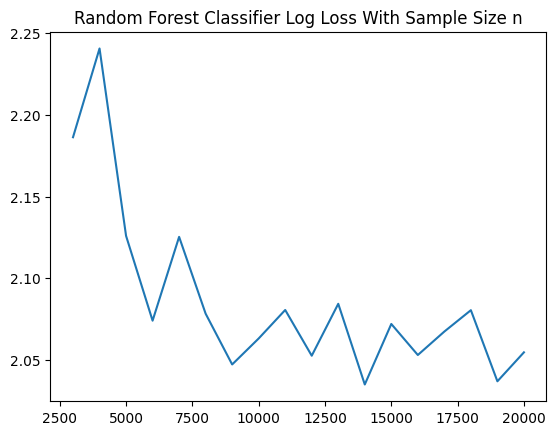

In [48]:
# Check approx where KNC error starts to plateau based on n instances for cutting off grid search and understanding training timing
plot_model_error_on_n(rf_classifier, 3000, 20000, "Random Forest Classifier")

In [49]:
# Test the basic Random Forest Classifier for use as a baseline
rf_scores = cross_val_score(rf_classifier, x_train[:50000], y_train[:50000], cv = 5, scoring = "neg_log_loss", verbose=4)
print("The Basic Random Forest Classifier Has a Neg Log Loss of: {}".format(round(rf_scores.mean(),3)))

[CV] END ............................... score: (test=-2.062) total time=  22.0s
[CV] END ............................... score: (test=-1.995) total time=  21.7s
[CV] END ............................... score: (test=-2.013) total time=  21.6s
[CV] END ............................... score: (test=-2.036) total time=  22.0s
[CV] END ............................... score: (test=-2.016) total time=  21.7s
The Basic Random Forest Classifier Has a Neg Log Loss of: -2.025


### Grid Search for Random Forest Classifier

In [50]:
# Detail parameters for the Random Forest Grid Search
estimators_params= [round(x) for x in np.linspace(600,2000,6)]
criterion_params = ["gini", "entropy", "log_loss"]
max_depth_params = [3, 4, 5]
min_sample_leaf_params = [round(x) for x in np.linspace(1,100,4)]

In [53]:
# Build a parameter grid for the Random Forest Classifier, and run the grid search
rf_parameters = {'n_estimators':estimators_params, "criterion":criterion_params, "max_depth":max_depth_params}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state = 42), rf_parameters, cv=5, scoring = "neg_log_loss", verbose = 3, n_jobs=5)
rf_grid_search.fit(x_train[:12000], y_train[:12000])
clear_output(wait=False)

In [58]:
# Print out grid search results
final_RF_regressor_plays = rf_grid_search.best_estimator_
print("The Best Random Forest Classifier Has a Neg Log Loss Of: {}".format(round(rf_grid_search.best_score_.mean(), 3)))
print("The Best K Neighbors Classifier Has Parameters Of: {}".format(rf_grid_search.best_params_))

final_rf_classifier = RandomForestClassifier(random_state=42, n_estimators=1720, criterion="entropy", max_depth=11) # It turns out that when we run on the full dataset, increasing the max depth from the grid search val is helpful

The Best Random Forest Classifier Has a Neg Log Loss Of: -1.627
The Best K Neighbors Classifier Has Parameters Of: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 1720}


In [59]:
# Double check that a higher n_estimators is not warrented when using a larger sample size
boosted_estimator_rf_scores = cross_val_score(final_rf_classifier, x_train[:100000], y_train[:100000], cv=5, verbose=4, scoring="neg_log_loss", n_jobs=5)
clear_output(wait=False)
print("The Random Forest Classifier With Optimized Estimators Has a Neg Log Loss of: {}".format(round(boosted_estimator_rf_scores.mean(),3)))

The Random Forest Classifier With Optimized Estimators Has a Neg Log Loss of: -1.599


## Histogram Based Gradient Boosting Classifier

Because of the testing limitations, we will also try a Histogram-based Gradient Boosting Classification Tree, which scales significantly better than the standard gradient boosting tree. It does not appear to support grid search however, so we will do that manually

In [62]:
# Check approx where HGB Classifier error starts to plateau based on n instances for cutting off grid search and understanding training timing
hgb_classifier = HistGradientBoostingClassifier()
plot_model_error_on_n(hgb_classifier, 3000, 20000, "Gradient Boosting Classifier")

Training Model on 4000 Instances
[CV] END ............................... score: (test=-2.349) total time=  10.6s
[CV] END ............................... score: (test=-2.365) total time=  10.8s


KeyboardInterrupt: 

In [65]:
hgb_classifier_scores = cross_val_score(hgb_classifier, x_train[:], y_train[:], cv=5, scoring="neg_log_loss", n_jobs = 5)
print("The Basic Hist Gradient Boosted Classifier Has a Neg Log Loss of: {}".format(round(hgb_classifier_scores.mean(),3)))

The Basic Hist Gradient Boosted Classifier Has a Neg Log Loss of: -1.617


In [69]:
iter_params = [100, 250, 500]
max_depth_params = [5, None]

all_param_lists = [iter_params, max_depth_params]

hgbc_param_list = list(itertools.product(*all_param_lists))

In [71]:
# Grid Search for the Plays Model
print("Grid Search For Plays")

best_score = -10000
best_params = {}
for tup in hgbc_param_list:
    print(tup)
    score = cross_val_score(HistGradientBoostingClassifier(max_iter=tup[0], max_depth = tup[1]), x_train[:150000], y_train[:150000], cv=5,
                                                          n_jobs = 5, scoring="neg_log_loss").mean()
    
    if score > best_score:
        best_score = score
        best_params = {"max_iter":tup[0], "max_depth":tup[1]}
                            
    clear_output(wait=False)

In [72]:
# Create a final HGB Classifier based on the results of the grid search and print the results
final_hgb_classifier = HistGradientBoostingClassifier(max_iter=best_params["max_iter"], max_depth = best_params["max_depth"])
print("The Best Histogram-Based Gradient Boosted Classifier Has a Neg Log Loss Of: {}".format(round(best_score, 3)))
print("The Best Histogram-Based Gradient Boosted Classifier Has Parameters Of: {}".format(best_params))

The Best Histogram-Based Gradient Boosted Classifier Has a Neg Log Loss Of: -1.581
The Best Histogram-Based Gradient Boosted Classifier Has Parameters Of: {'max_iter': 500, 'max_depth': 5}


In [73]:
# Because we grid searched for parameters on a smaller dataset, run the final estimator on a larger dataset for a best score
final_hgb_classifier_scores = cross_val_score(final_hgb_classifier, x_train[:], y_train[:], cv=5, scoring = "neg_log_loss", n_jobs=5, verbose=3)
clear_output(wait=False)
print("The Final Histogram Based Gradient Boosting Classifier Has a Neg Log Loss of: {}".format(round(final_hgb_classifier_scores.mean(),3)))

The Final Histogram Based Gradient Boosting Classifier Has a Neg Log Loss of: -1.582


## ADA Boost Classifier

### Basic ADA Boost Classifier

In [78]:
abc = AdaBoostClassifier()

TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'n_jobs'

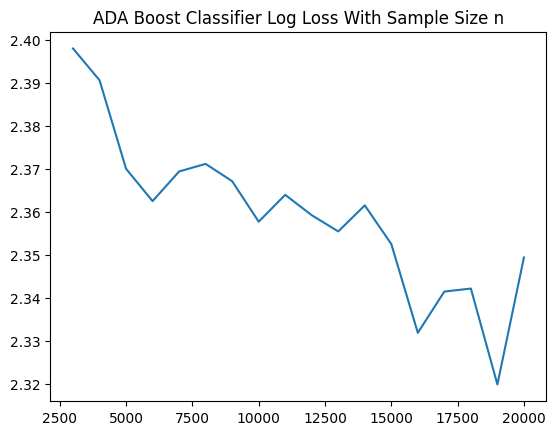

In [79]:
# Check approx where ADA Boost Classifier error starts to plateau based on n instances for cutting off grid search and understanding training timing
plot_model_error_on_n(abc, 3000, 20000, "ADA Boost Classifier")

In [81]:
# Test the Basic ADA Boost Classifier to get a baseline score
abc_scores = cross_val_score(abc, x_train[:], y_train[:], cv=5, scoring="neg_log_loss", n_jobs = 5)
print("The Basic ADA Boost Classifier Has a Neg Log Loss of: {}".format(round(abc_scores.mean(),3)))

/Users/jaredzirkes/pyvenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/jaredzirkes/pyvenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/jaredzirkes/pyvenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/jaredzirkes/pyvenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circum

The Basic ADA Boost Classifier Has a Neg Log Loss of: -2.355


### Grid Search for ADA Boost Classifier

In [82]:
# Build a parameter grid for searching with the ADA Boost Classifier
weak_learner_params = [DecisionTreeClassifier(max_depth=x) for x in [1,2,None]]+ [LogisticRegression()]
n_estimators_params = [8, 10, 12, 20]

In [84]:
# Run the grid search for the ADA Boost Classifier
abc_parameters = {'n_estimators':n_estimators_params, "estimator":weak_learner_params}
abc_grid_search = GridSearchCV(AdaBoostClassifier(), abc_parameters, cv=5, scoring = "neg_log_loss", verbose = 3, n_jobs=5)
abc_grid_search.fit(x_train[:30000], y_train[:30000])
clear_output(wait=False)

In [86]:
# Print grid search results for the ADA Boost Classifier
final_abc_classifier = abc_grid_search.best_estimator_
print("The Best Ada Boost Classifier Has a Neg Log Loss Of: {}".format(round(abc_grid_search.best_score_, 3)))
print("The Best Ada Boost Classifier Has Parameters Of: {}".format(abc_grid_search.best_params_))

The Best Ada Boost Classifier Has a Neg Log Loss Of: -2.092
The Best Ada Boost Classifier Has Parameters Of: {'estimator': DecisionTreeClassifier(max_depth=2), 'n_estimators': 8}


In [87]:
# Because the grid search was run on a smaller sample, test the best grid search model on a larger sample
final_abc_scores = cross_val_score(final_abc_classifier, x_train[:], y_train[:], cv=5, scoring = "neg_log_loss", n_jobs=4, verbose=3)
clear_output(wait=False)
print("The ADA Boost Classifier Has a Neg Log Loss of: {}".format(round(final_abc_scores.mean(),3)))

The ADA Boost Classifier Has a Neg Log Loss of: -2.099


## XGBoost Classifier

In [18]:
y_train_encoded = OrdinalEncoder().fit_transform(np.array(y_train).reshape(-1,1))
y_train_encoded = [int(x[0]) for x in y_train_encoded]

### Basic XGBoost Classifier

In [91]:
# Set up the base XGBoost Classifier
xgb = XGBClassifier()

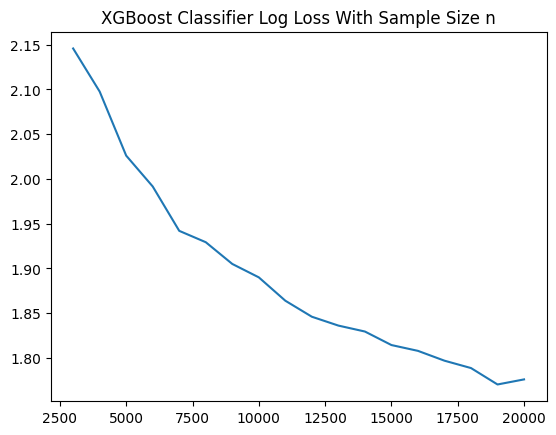

In [94]:
# Check approx where XGBoost Classifier error starts to plateau based on n instances for cutting off grid search and understanding training timing
plot_model_error_on_n(xgb, 3000, 20000, "XGBoost Classifier", y_train=y_train_encoded)

In [95]:
# Check the baseline
xgb_scores = cross_val_score(xgb, x_train[:50000], y_train_encoded[:50000], cv=5, scoring="neg_log_loss", n_jobs=5, verbose = 3)
print("The Basic XGBoost Boost Classifier Has a Neg Log Loss of: {}".format(round(xgb_scores.mean(),3)))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END ............................... score: (test=-1.670) total time=  20.1s
[CV] END ............................... score: (test=-1.658) total time=  20.3s
[CV] END ............................... score: (test=-1.669) total time=  20.4s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   20.4s remaining:   30.6s


[CV] END ............................... score: (test=-1.665) total time=  20.6s
[CV] END ............................... score: (test=-1.673) total time=  20.6s
The Basic XGBoost Boost Classifier Has a Neg Log Loss of: -1.667


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   20.7s finished


### Grid Search for XGBoostClassifier

In [96]:
child_weight_params = [1, 3, 6]
gamma_params = [.5, 1, 1.5]
subsample_params = [.6, .8]
colsample_bytree_params = [.6, .8]
max_depth_params = [1,2,5]
alpha_params = [.5, 1]

In [98]:
xgb_params = {'min_child_weight': child_weight_params,'gamma': gamma_params,'subsample': subsample_params,
              'colsample_bytree': colsample_bytree_params,'max_depth': max_depth_params, "alpha":alpha_params}

xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_params, cv=5, scoring = "neg_log_loss", verbose = 3, n_jobs=5)
xgb_grid_search.fit(x_train[:30000], y_train_encoded[:30000])
clear_output(wait=False)

In [99]:
final_xgb = xgb_grid_search.best_estimator_
print("The Best XGBoost Classifier Has a Neg Log Loss Of: {}".format(round(xgb_grid_search.best_score_, 3)))
print("The Best XABoost Classifier Has Parameters Of: {}".format(xgb_grid_search.best_params_))

The Best XGBoost Classifier Has a Neg Log Loss Of: -1.59
The Best XABoost Classifier Has Parameters Of: {'alpha': 1, 'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.8}


In [100]:
final_xgb_scores = cross_val_score(xgb_grid_search.best_estimator_, x_train, y_train_encoded, cv=5, scoring="neg_log_loss", verbose=3, n_jobs=5)
print("The Final XGBoost Classifier Has a Neg Log Loss Of: {}".format(round(final_xgb_scores.mean(), 3)))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END ............................... score: (test=-1.583) total time=  52.8s
[CV] END ............................... score: (test=-1.583) total time=  53.7s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   54.9s remaining:  1.4min


[CV] END ............................... score: (test=-1.581) total time=  54.0s
[CV] END ............................... score: (test=-1.582) total time=  54.1s
[CV] END ............................... score: (test=-1.583) total time=  54.2s
The Final XGBoost Classifier Has a Neg Log Loss Of: -1.582


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   55.4s finished


## Neural Network

In [19]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

In [23]:
def run_neural_network(list_nodes, features=63, categories=12, x_train=x_train, y_train=y_train_encoded):
    callback = tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_crossentropy', patience=5, start_from_epoch=4, restore_best_weights = True)

    # Create a Sequential model
    model = Sequential()

    # Add the first hidden layer with 10 nodes and specify the input shape (54 inputs)
    model.add(Dense(list_nodes[0], input_shape=(features,), activation='relu'))
    
    for layer in range(len(list_nodes)-1):
        # Add the second hidden layer with 10 nodes
        model.add(Dense(list_nodes[layer+1], activation='relu'))

    # Add the output layer with 13 nodes 
    model.add(Dense(categories, activation='softmax'))

    # Call model on a test input
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_crossentropy'])
    # fit the keras model on the dataset
    model_history = model.fit(x_train, np.array(y_train_encoded), epochs=150, batch_size=10, callbacks = [callback])
    
    return {"final_model":model, "model_history":model_history} 


In [25]:
best_model = run_neural_network([64, 32, 18, 8, 4]) # For now, run an initial neural network on the grid search that worked best last time

Epoch 1/150
12624/12624 ━━━━━━━━━━━━━━━━━━━━ 6s 413us/step - loss: 1.6980 - sparse_categorical_crossentropy: 1.6980
Epoch 2/150
12624/12624 ━━━━━━━━━━━━━━━━━━━━ 5s 408us/step - loss: 1.6309 - sparse_categorical_crossentropy: 1.6309
Epoch 3/150
12624/12624 ━━━━━━━━━━━━━━━━━━━━ 5s 412us/step - loss: 1.6195 - sparse_categorical_crossentropy: 1.6195
Epoch 4/150
12624/12624 ━━━━━━━━━━━━━━━━━━━━ 5s 408us/step - loss: 1.6040 - sparse_categorical_crossentropy: 1.6040
Epoch 5/150
12624/12624 ━━━━━━━━━━━━━━━━━━━━ 5s 413us/step - loss: 1.5988 - sparse_categorical_crossentropy: 1.5988
Epoch 6/150
12624/12624 ━━━━━━━━━━━━━━━━━━━━ 5s 409us/step - loss: 1.5952 - sparse_categorical_crossentropy: 1.5952
Epoch 7/150
12624/12624 ━━━━━━━━━━━━━━━━━━━━ 5s 411us/step - loss: 1.5966 - sparse_categorical_crossentropy: 1.5966
Epoch 8/150
12624/12624 ━━━━━━━━━━━━━━━━━━━━ 5s 408us/step - loss: 1.5918 - sparse_categorical_crossentropy: 1.5918
Epoch 9/150
12624/12624 ━━━━━━━━━━━━━━━━━━━━ 5s 411us/step - loss: 1.590

### Grid Search Neural Network Layers

In [356]:
models = []
scores = []

best_model = None
best_score = 10000

In [359]:
for n in range(30):
    print("Running NN Number {}".format(n+1))
    
    layers1 = np.random.randint(100,size=np.random.randint(4,size = 1)[0]+1)
    layers2 = [layers1[0] for n in layers1]
    
    current_score = 100000
    
    model1 = run_neural_network(layers1)
    models.append([layer.output_shape[1] for layer in model1["final_model"].layers])
    scores.append(min(model1["model_history"].history["loss"]))
    
    if min(model1["model_history"].history["loss"]) < best_score:
        best_score = scores[-1]
        best_model = models[-1]
        
    print("\n\n\n Running Even Layered NN Number {}".format(n+1))
    model2 = run_neural_network(layers2)
    models.append([layer.output_shape[1] for layer in model2["final_model"].layers])
    scores.append(min(model2["model_history"].history["loss"]))
    
    if min(model2["model_history"].history["loss"]) < best_score:
        best_score = scores[-1]
        best_model = models[-1]  
        
clear_output(wait=False)

In [18]:
final_logistic_regressor = models['Logistic Regression']['Model']
final_KNC_classifier = models['']
final_rf_classifier
final_hgb_classifier
final_abc_classifier
final_xgb
best_model

In [17]:
model_summary = {"Baseline Guesser":{"Model":None, "Score":dumb_log_loss_plays},
                 "Logistic Regression":{"Model":final_logistic_regressor, "Score":round(final_softmax_scores.mean(),3)},
                 "K-Neighbors":{"Model":final_KNC_classifier, "Score":round(final_KNC_scores.mean(),3)},
                 "Random Forest":{"Model":final_rf_classifier, "Score":round(boosted_estimator_rf_scores.mean(),3)},
                 "Gradient Boosting":{"Model":final_hgb_classifier, "Score":round(final_hgb_classifier_scores.mean(),3)},
                 "ADA Boost":{"Model":final_abc_classifier, "Score":round(final_abc_scores.mean(),3)},
                 "XGBoost":{"Model":final_xgb, "Score":round(final_xgb_scores.mean(),3)},
                 "Neural Network":{"Model":best_model, "Score":min(best_model["model_history"].history["loss"]) * -1}}

summary_df = pd.DataFrame({"Models":model_summary.keys(), "Scores":[round(model_summary[key]["Score"]*-1,2) for key in model_summary]})
summary_df = summary_df.sort_values(by='Scores', ascending=False).reset_index()

NameError: name 'final_logistic_regressor' is not defined

NameError: name 'summary_df' is not defined

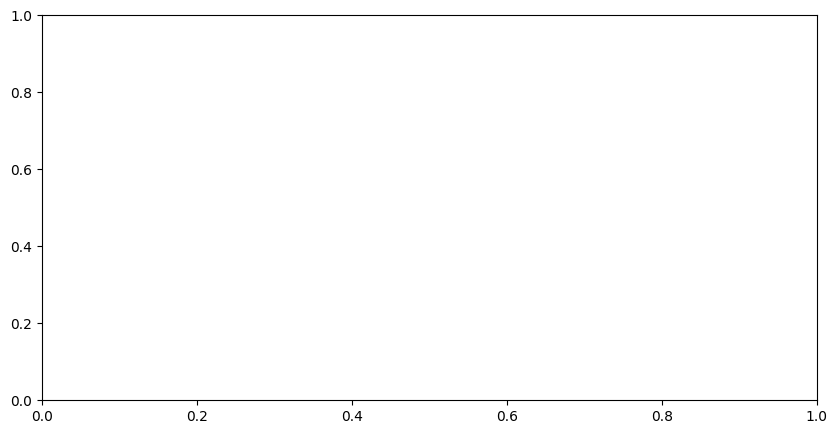

In [16]:
# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(summary_df.Models, summary_df.Scores)

ax.tick_params(axis='x', labelrotation=45, labelsize=12)
ax.axhline(y = -model_summary["Baseline Guesser"]["Score"], color = 'k', linestyle = 'dashed')     
ax.set_title("Final Log Loss by Model", fontsize=16)

# Add values on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height-.4, f'{height}', 
            ha='center', va='bottom', fontsize=11)

In [133]:
#pkl.dump(model_summary, open("Summary of Models.pkl", "wb"))

In [3]:
models = pkl.load(open("Summary of Models.pkl", "rb"))

In [135]:
models

{'Baseline Guesser': {'Model': None, 'Score': -1.6708149742997287},
 'Logistic Regression': {'Model': LogisticRegression(C=0.1675, multi_class='ovr', solver='saga'),
  'Score': -1.589},
 'K-Neighbors': {'Model': KNeighborsClassifier(n_neighbors=1626, weights='distance'),
  'Score': -1.637},
 'Random Forest': {'Model': RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=1720,
                         random_state=42),
  'Score': -1.599},
 'Gradient Boosting': {'Model': HistGradientBoostingClassifier(max_depth=5, max_iter=500),
  'Score': -1.582},
 'ADA Boost': {'Model': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                     n_estimators=8),
  'Score': -2.099},
 'XGBoost': {'Model': XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.8, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_